In [1539]:
import requests
from tqdm.auto import tqdm
import time #для цикла, чтобы сделать паузу между обращениями к api hh
import joblib # для сохранкения дампа в файл
import math # для окпругления в большую сторону
import pandas as pd
from datetime import datetime # для работы с дата время
import re
import plotly.express as px
#для переворота словаря
from operator import itemgetter
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt

import nltk #стоп слова
import ssl #стоп слова
from nltk.corpus import stopwords
import pymorphy2 #для лемматизации
#для прогнозов sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics.pairwise import cosine_similarity

RANDOM_STATE=123






# Запрос вакансий с hh.ru

### Определим список городом где есть площадки МЦТП УП АРМ (мое подразделение) и для сравнения добавим туда Москву и Питер

In [2]:
cities = ['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Нижний Новгород',  'Самара', 'Тула']

### Выясним номера регионов

In [29]:
areas = []
for city in cities:
    url = f'https://api.hh.ru/suggests/area_leaves?text={city}'
    res = requests.get(url)
    for item in res.json()['items']:
        if item['text'] in cities:
            areas.append(item)

In [31]:
areas

[{'id': '1', 'text': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 {'id': '2', 'text': 'Санкт-Петербург', 'url': 'https://api.hh.ru/areas/2'},
 {'id': '4', 'text': 'Новосибирск', 'url': 'https://api.hh.ru/areas/4'},
 {'id': '3', 'text': 'Екатеринбург', 'url': 'https://api.hh.ru/areas/3'},
 {'id': '66', 'text': 'Нижний Новгород', 'url': 'https://api.hh.ru/areas/66'},
 {'id': '78', 'text': 'Самара', 'url': 'https://api.hh.ru/areas/78'},
 {'id': '92', 'text': 'Тула', 'url': 'https://api.hh.ru/areas/92'}]

### Сохраним все номера id вакансий

In [68]:
%%time

page = 1
num_per_page = 100
all_vacancy_ids=[]
for region in tqdm(range(len(areas))):
    reg_id = areas[region]['id']
    time.sleep(60)
    #print(reg_id)
    url = f'https://api.hh.ru/vacancies?&page={page}&per_page={num_per_page}&area={reg_id}'
    for i in range(20):
        res = requests.get(url)
        vacancies = res.json()
        num_pages = vacancies.get('pages')
        vacancy_ids = [el.get('id') for el in vacancies.get('items')]
        all_vacancy_ids.extend(vacancy_ids)
        

  0%|          | 0/7 [00:00<?, ?it/s]

In [72]:
%%time
#сохраним номера вакансий в файл
#
joblib.dump(all_vacancy_ids,'all_vacancy_ids_dump')


['all_vacancy_ids_dump']

In [ ]:
#чтобы открыть =joblib.load('all_vacancy_ids_dump')

### проверяем число вакансий

In [73]:
len(all_vacancy_ids)

14000

### Скачиваем все по вакансиям, подробно с навыками и тд

In [111]:
%%time

vacancy_all_info = []
all_iteration = math.ceil((len(all_vacancy_ids))/50) #делим все вакансии на 50, и округляем в большую сторону.
for ii in range(all_iteration): #создал цикл по 50  вакнсий
    # Запрос исполняется Wall time: 5h 17min 16s
    x=50*ii
    ii+=1
    y=50*ii
    for i in range(x, y): #перебор вакансий с 0 по 49, с  50 по 99 и тд
        vac_id = all_vacancy_ids[i]
        url = f'https://api.hh.ru/vacancies/{vac_id}'
        res = requests.get(url)
        vacancy = res.json()
        vacancy_all_info.append(vacancy)
    #print(ii)
    time.sleep(60) #пауза в 60 секунд после каждого запроса на 50 вакансий, чтобы небыло капчи

Wall time: 5h 17min 16s


In [112]:
%%time
#сохраним номера вакансий в файл
#
joblib.dump(vacancy_all_info,'vacancy_all_info_dump')

Wall time: 14.2 s


['vacancy_all_info_dump']

In [1192]:
#посмотрим на одну вакансию
vacancy_all_info[4000]

{'id': '78393684',
 'premium': False,
 'billing_type': {'id': 'standard', 'name': 'Стандарт'},
 'relations': [],
 'name': 'Сотрудник на производство картин по номерам',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '4',
  'name': 'Новосибирск',
  'url': 'https://api.hh.ru/areas/4'},
 'salary': {'from': 36000, 'to': 40000, 'currency': 'RUR', 'gross': False},
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'allow_messages': True,
 'experience': {'id': 'noExperience', 'name': 'Нет опыта'},
 'schedule': {'id': 'fullDay', 'name': 'Полный день'},
 'employment': {'id': 'full', 'name': 'Полная занятость'},
 'department': None,
 'contacts': None,
 'description': '<p><em><strong>Мы ищем сотрудников на производство картин по номерам. Нам нужны трудолюбивые, ответственные люди. </strong></em></p> <p><em><strong>Эта работа для вас:</strong></em></p> <p><em><strong>если вы любите выполнять монотонную работу;</strong></em></p> <p><em><strong>если у ва

### Создаем DataFrame с нужными нам полями из всего массива данных

In [1193]:

vac_info = pd.DataFrame(vacancy_all_info, columns = ['id', 'name', 'area','salary', 'experience', 'schedule', 
                                                     'employment', 'description', 'key_skills', 'professional_roles', 
                                                     'employer', 'published_at'])

In [1194]:
#vac_info.info()

### Работаем с данными, очищаем, выбираем нужное и тд, в том числе через написанные функции

In [1196]:
def name_of_property (slovar):
    """
    функция вытягивания конкретного свойства из поля
    """
    name_prop = slovar['name']
    return name_prop

In [1197]:
# применем функцию и оставим нужные нам свойства
vac_info['area'] = vac_info['area'].apply(name_of_property)
vac_info['experience'] = vac_info['experience'].apply(name_of_property)
vac_info['schedule'] = vac_info['schedule'].apply(name_of_property)
vac_info['employment'] = vac_info['employment'].apply(name_of_property)
vac_info['employer'] = vac_info['employer'].apply(name_of_property)

In [1198]:
def name_professional_roles (slovar):
    """
    функция вытягивания конкретного свойства из поля professional_roles
    """
    name_prop = slovar[0]['name']
    return name_prop

In [1199]:
vac_info['professional_roles']=vac_info['professional_roles'].apply(name_professional_roles)

In [1200]:
#функции для разбора поля salary на зарплату от и до 
def salary_from (slovar):
    """
    функция зарплата от
    """
    if type(slovar) ==dict:
        if type(slovar['from']) == int:
            salary_from = slovar['from']
            return salary_from

def salary_to (slovar):
    """
    функция зарплата до
    """
    if type(slovar) ==dict:
        if type(slovar['to']) == int:
            salary_to = slovar['to']
            return salary_to

In [1201]:
#применим функции зарплат
vac_info['salary_from'] = vac_info['salary'].apply(salary_from)
vac_info['salary_to'] = vac_info['salary'].apply(salary_to)

In [1202]:
# создаем функцию для конвертации в дату столбца 'published_at'
def convert_datetime(x):
    """
    переводим строку в дату 
    """
    if type(x)==str:
        new_x = datetime.strptime(x[:10], '%Y-%m-%d')
        return new_x
    else :
        new_x = None  # не знал как обойти когда вместо строки приходит что то иное
        return new_x

In [1203]:
vac_info['published_at']=vac_info['published_at'].apply(convert_datetime)

In [1204]:
#функция для преобразования требований в один список удобный нам
def vac_skill(list_skill):
    """
    Перебираем все существующие требования к навыкам в поле key_skills и записываем их в лист
    """
    if len(list_skill) != 0: #смотрим только существующие значения
        skill = []
        for i in range(len(list_skill)): 
            skill.append(list_skill[i]['name'])
        return skill

In [1205]:
vac_info['key_skills']=vac_info['key_skills'].apply(vac_skill)

### выберем из vac_info.professional_roles.unique() цифровые специальности(смотрел что вообще дает HH и выбрал что связано с IT)

In [1206]:

spisok = ['Тестировщик', 'Программист, разработчик','Специалист технической поддержки', 
          'Продуктовый аналитик', 'Руководитель группы разработки', 'Системный администратор', 'Менеджер продукта']

In [1207]:
def find_vasc_roles (stroka):
    """
    функция поиска цифровых вакансий
    """
    sovpalo = 0
    for x in range(len(spisok)):
        if (spisok[x] == stroka) == True:
            sovpalo+=1
        #else: return 0
    if sovpalo > 0 : return 1
    else: return 0

In [1208]:
# проставим flag = 1 там где цифровые вакансии
vac_info['flag'] = vac_info['professional_roles'].apply(find_vasc_roles)

In [1516]:
vac_info_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  1120 non-null   object        
 1   name                1120 non-null   object        
 2   area                1120 non-null   object        
 3   salary              660 non-null    object        
 4   experience          1120 non-null   object        
 5   schedule            1120 non-null   object        
 6   employment          1120 non-null   object        
 7   description         1120 non-null   object        
 8   key_skills          780 non-null    object        
 9   professional_roles  1120 non-null   object        
 10  employer            1120 non-null   object        
 11  published_at        1120 non-null   datetime64[ns]
 12  salary_from         600 non-null    float64       
 13  salary_to           300 non-null    float64     

In [1209]:
#создаим копию датасета, и поработаем с данными
vac_info_new = vac_info.loc[vac_info['flag']==1].reset_index(drop=True).copy()

In [1210]:
def vac_level(row):
    """
    функия опредления уровня вакансии из названия
    """
    if ('junior' in row)|('младший' in row)|('стажер' in row):
        return 'Junior'
    if 'middle' in row:
        return 'Middle'
    if ('senior' in row)|('старший' in row):
        return 'Senior'
    if ('chief' in row)|('head' in row)|('lead' in row)|('руководитель' in row):
        return 'Lead'

In [1211]:
vac_info_new['vac_level']=vac_info_new['name'].apply(vac_level)

In [1517]:
#Смотрим какие уровни есть
vac_info_new['vac_level'].unique()

array([None, 'Junior'], dtype=object)

### К сожалению у нас уровень только новичок, исследования относительно уровня провести невозможно

In [1214]:
#оценим данные
vac_info_new.isna().sum()

id                       0
name                     0
area                     0
salary                 460
experience               0
schedule                 0
employment               0
description              0
key_skills             340
professional_roles       0
employer                 0
published_at             0
salary_from            520
salary_to              820
flag                     0
vac_level             1040
dtype: int64

### Построим график уровень зарплат от какой суммы (там где данные есть). Нижняя планка зарплат.


In [1316]:

vac_info_new_salary_from = vac_info_new[vac_info_new['salary_from'].notnull()].copy()
table_for_plot = vac_info_new_salary_from
fig = px.box(table_for_plot, 
             x="area", 
             y="salary_from", 
             color = "area", 
             category_orders = {'area': table_for_plot['area'].value_counts().index}, 
             labels = {'area':'Регион', 'salary_from':'Зарплата от, руб.'})
fig.show()

### Построим диаграмму рассеивания 

In [1353]:
vac_info_new_salary_from_key_count = vac_info_new_salary_from.copy().reset_index(drop=True)
vac_info_new_salary_from_key_count.head(2)

,id,name,area,salary,experience,schedule,employment,description,key_skills,professional_roles,employer,published_at,salary_from,salary_to,flag,vac_level
0,79912022,Специалист по тестированию ПО,Москва,"{'from': 60000, 'to': None, 'currency': 'RUR',...",От 1 года до 3 лет,Полный день,Полная занятость,"Мы ищем QA-инженера, который будет заниматься ...",None,Тестировщик,Долг-контроль,2023-04-28,60000.0,NaN,1,None
1,79295936,Junior Web-разработчик,Москва,"{'from': 60000, 'to': None, 'currency': 'RUR',...",Нет опыта,Полный день,Полная занятость,<p>В веб студию <strong>Easy IT</strong> требу...,"[PHP, MySQL, HTML5, CSS3, JavaScript]","Программист, разработчик",EasyIT,2023-04-24,60000.0,NaN,1,None


In [1348]:
def key_skills_to_int(x):
    """
    подсчет количества навыков
    """
    if x == None:
        return 0
    else: 
        y=len(x)
        return y


In [1355]:
vac_info_new_salary_from_key_count['key_skills_count']=vac_info_new_salary_from_key_count['key_skills'].apply(key_skills_to_int)

In [1357]:
vac_info_new_salary_from_key_count.head(4)

,id,name,area,salary,experience,schedule,employment,description,key_skills,professional_roles,employer,published_at,salary_from,salary_to,flag,vac_level,key_skills_count
0,79912022,Специалист по тестированию ПО,Москва,"{'from': 60000, 'to': None, 'currency': 'RUR',...",От 1 года до 3 лет,Полный день,Полная занятость,"Мы ищем QA-инженера, который будет заниматься ...",None,Тестировщик,Долг-контроль,2023-04-28,60000.0,NaN,1,None,0
1,79295936,Junior Web-разработчик,Москва,"{'from': 60000, 'to': None, 'currency': 'RUR',...",Нет опыта,Полный день,Полная занятость,<p>В веб студию <strong>Easy IT</strong> требу...,"[PHP, MySQL, HTML5, CSS3, JavaScript]","Программист, разработчик",EasyIT,2023-04-24,60000.0,NaN,1,None,5
2,79879224,Тестировщик ПО / QA,Москва,"{'from': 60000, 'to': 90000, 'currency': 'RUR'...",Нет опыта,Полный день,Полная занятость,<p>Группа компаний МЗТА</p> <p>&quot;РТК Автом...,"[Тестирование десктопных приложений, Тестирова...",Тестировщик,РТК Автоматика,2023-04-27,60000.0,90000.0,1,None,5
3,79715558,Junior Project Manager,Москва,"{'from': 130000, 'to': None, 'currency': 'RUR'...",От 1 года до 3 лет,Полный день,Полная занятость,<p><strong>Responsibilities: </strong></p> <p>...,"[Английский язык, MS PowerPoint, Time manageme...",Менеджер продукта,ECCO,2023-04-24,130000.0,NaN,1,None,9


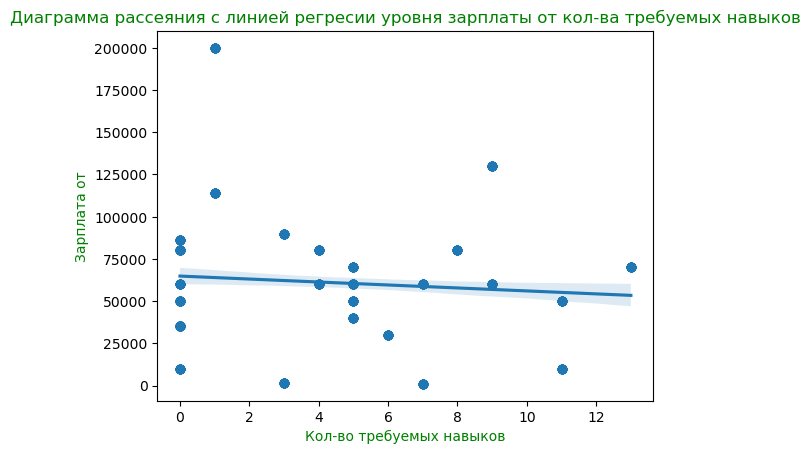

In [1478]:
sns.regplot(
    x='key_skills_count',
    y='salary_from',
    data=vac_info_new_salary_from_key_count,
)
plt.ylabel('Зарплата от', color='g')
plt.xlabel('Кол-во требуемых навыков', color='g')
plt.title('Диаграмма рассеяния с линией регресии уровня зарплаты от кол-ва требуемых навыков', color='g');
plt.show()

#### Вывод: от количества навыков зарплата не зависит на прямую, могут требовать навыки, но зарплата будет не высокой.

### Посмотрим зависимость средней зарплаты в профессии от опыта


In [1392]:
vac_info_new_salary_from.head(3)

,id,name,area,salary,experience,schedule,employment,description,key_skills,professional_roles,employer,published_at,salary_from,salary_to,flag,vac_level
2,79912022,Специалист по тестированию ПО,Москва,"{'from': 60000, 'to': None, 'currency': 'RUR',...",От 1 года до 3 лет,Полный день,Полная занятость,"Мы ищем QA-инженера, который будет заниматься ...",None,Тестировщик,Долг-контроль,2023-04-28,60000.0,NaN,1,None
5,79295936,Junior Web-разработчик,Москва,"{'from': 60000, 'to': None, 'currency': 'RUR',...",Нет опыта,Полный день,Полная занятость,<p>В веб студию <strong>Easy IT</strong> требу...,"[PHP, MySQL, HTML5, CSS3, JavaScript]","Программист, разработчик",EasyIT,2023-04-24,60000.0,NaN,1,None
10,79879224,Тестировщик ПО / QA,Москва,"{'from': 60000, 'to': 90000, 'currency': 'RUR'...",Нет опыта,Полный день,Полная занятость,<p>Группа компаний МЗТА</p> <p>&quot;РТК Автом...,"[Тестирование десктопных приложений, Тестирова...",Тестировщик,РТК Автоматика,2023-04-27,60000.0,90000.0,1,None


In [1465]:
vac_salary_from_heatmap = vac_info_new_salary_from.copy().reset_index(drop=True)
vac_salary_from_heatmap = vac_salary_from_heatmap.filter(items = ["experience","professional_roles", "salary_from"])
vac_salary_from_heatmap.head(3)

,experience,professional_roles,salary_from
0,От 1 года до 3 лет,Тестировщик,60000.0
1,Нет опыта,"Программист, разработчик",60000.0
2,Нет опыта,Тестировщик,60000.0


In [1400]:
def experience_count(x):
    """
    0 - можно без навыка
    3- От 1 года до 3 лет
    6 - 'От 3 до 6 лет'
    """ 
    if x=='Нет опыта': return 0
    if x=='От 1 года до 3 лет': return 3
    if x=='От 3 до 6 лет': return 6
    

In [1448]:
vac_salary_from_heatmap['experience'] = vac_salary_from_heatmap['experience'].apply(experience_count)

In [1449]:
vac_salary_from_heatmap.head(3)

,experience,professional_roles,salary_from
0,3,Тестировщик,60000.0
1,0,"Программист, разработчик",60000.0
2,0,Тестировщик,60000.0


In [1472]:
g = pd.pivot_table(vac_salary_from_heatmap,
                  index='professional_roles' ,
                  columns = 'experience',
                  values='salary_from',
                  aggfunc='mean')
#g=g.fillna(0)
g.head()

experience,Нет опыта,От 1 года до 3 лет,От 3 до 6 лет
professional_roles,,,
Менеджер продукта,NaN,130000.000000,NaN
"Программист, разработчик",56250.0,78777.777778,NaN
Продуктовый аналитик,1000.0,NaN,NaN
Руководитель группы разработки,10000.0,NaN,NaN
Системный администратор,45000.0,86000.000000,NaN


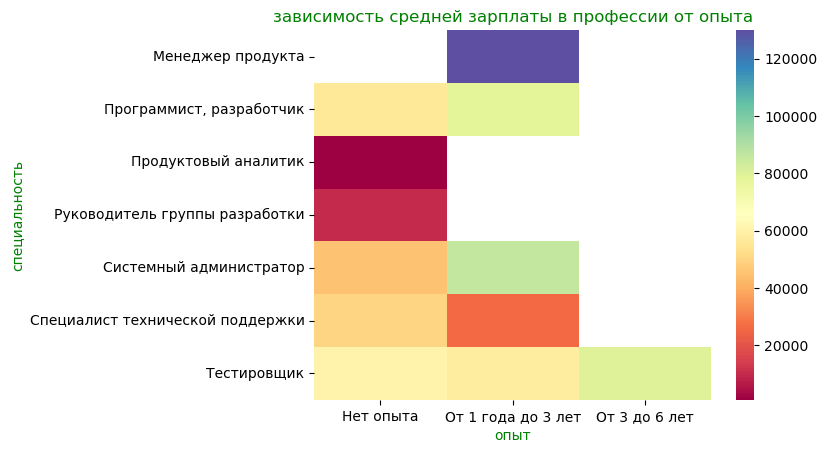

In [1475]:
sns.heatmap(g,
           cmap="Spectral")
plt.ylabel('специальность', color='g')
plt.xlabel('опыт', color='g')
plt.title('зависимость средней зарплаты в профессии от опыта', color='g');
plt.show()

### Построим график уровень зарплат до (там где данные есть). Верхняя планка(потолок) зарплат.

In [1317]:

vac_info_new_salary_to = vac_info_new[vac_info_new['salary_to'].notnull()].copy()
table_for_plot = vac_info_new_salary_to
fig = px.box(table_for_plot, 
             x="area", 
             y="salary_to", 
             color = "area", 
             category_orders = {'area': table_for_plot['area'].value_counts().index}, 
             labels = {'area':'Регион', 'salary_to':'Зарплата от, руб.'})
fig.show()

### Видим из двух графиков как выровнялась сетка зарплат, вероятно из за ковида

### Определим топ 20 популярных навыков и отобразим на графике

In [1219]:
#
skills_table = vac_info_new.copy()
skills_table = skills_table.filter(items = ["id", "name", "key_skills","salary_from","Level"])
skills_table_count = skills_table.explode("key_skills").groupby("key_skills").count()['id']
skills_table_count = pd.DataFrame(skills_table_count).rename(mapper = {'id':'count'}, axis = 1)
skills_table_count = skills_table_count.sort_values(by = 'count',ascending = False)
skills_table_count.head(20)

,count
key_skills,
SQL,220
JavaScript,200
Тестирование,160
Python,100
Atlassian Jira,80
HTML,80
TypeScript,80
Git,80
QA,80


In [1220]:
#
fig = px.bar(skills_table_count.head(20),labels = {'key_skills':'Навык', 'value':'Количество вакансий'})
fig.update_layout(showlegend=False)
fig.show()

### Вывод : SQL и Python входят в топ 5 самых востребованных навыков

### Посторим график процентов наиболее востребованных навыков в виде круговой диаграммы

In [1221]:

skills_table_count_new = skills_table_count.head(20).copy()
skills_table_count_new = skills_table_count_new.reset_index()

In [1222]:
pyplt=py.offline.plot
labels=list(skills_table_count_new['key_skills'])
values=list(skills_table_count_new['count'])
trace=[go.Pie(labels=labels,values=values)]
layout=go.Layout(
    title='График процентов наиболее востребованных навыков'
)
fig=go.Figure(data=trace,layout=layout)
fig.show()

### Определим самые оплачиваемые навыки по среднему уровню зарплат и отобразим на графике

In [1223]:
#
skills_salary_table = skills_table.explode("key_skills").groupby("key_skills").mean().reset_index()
skills_salary_table = skills_salary_table.dropna(axis=0).sort_values(by='salary_from',ascending = False)
#skills_salary_table

In [1224]:
def trim_string(x):
    """
    отрежем первые 25 символов навыка, для красоты отображения на графике
    """
    y=x[0:25]
    return y

In [1225]:
skills_salary_table['key_skills']=skills_salary_table['key_skills'].apply(trim_string)

In [1226]:
skills_salary_table = skills_salary_table.set_index(['key_skills'])

In [1233]:
#skills_salary_table.head(20)

In [1228]:
#отобразим на графике самые оплачиваемые навыки 
fig = px.bar(skills_salary_table.head(20),labels = {'skills':'Навык', 'value':'Средняя зарплата по вакансиям с навыком'})
fig.update_layout(showlegend=False)
fig.show()

### Вывод: за исключением 1С самыми оплачиваемыми навыками являются soft навыки (ведение документации, планирование, презентации и тд)

### Посторим график процентов наиболее оплачиваемых навыков в виде круговой диаграммы

In [1234]:

skills_salary_table_new = skills_salary_table.head(20).copy()
skills_salary_table_new = skills_salary_table_new.reset_index(drop = False)

In [1238]:
pyplt=py.offline.plot
labels=list(skills_salary_table_new['key_skills'])
values=list(skills_salary_table_new['salary_from'])
trace=[go.Pie(labels=labels,values=values)]
layout=go.Layout(
    title='График процентов наиболее оплачиваемых навыков'
)
fig=go.Figure(data=trace,layout=layout)
fig.show()

### Оценим количество вакансий по городам с навыками SQL и Python

In [1239]:
# 
area_table = vac_info_new.copy()
area_table = employer_table.filter(items = ["id", "employer","key_skills","area"])
area_table= employer_table.explode("key_skills")


In [1240]:
area_table_count_sql = area_table[employer_table['key_skills']=='SQL'].groupby(['area']).count()['id']
area_table_count_sql = pd.DataFrame(area_table_count_sql).rename(mapper = {'id':'count'}, axis = 1)
area_table_count_sql  = area_table_count_sql.sort_values(by = 'count',ascending = False).reset_index()

In [1241]:
area_table_count_Python = area_table[area_table['key_skills']=='Python'].groupby(['area']).count()['id']
area_table_count_Python = pd.DataFrame(area_table_count_Python).rename(mapper = {'id':'count'}, axis = 1)
area_table_count_Python  = area_table_count_Python.sort_values(by = 'count',ascending = False).reset_index()

In [1242]:
# отобразим на графике
fig = make_subplots(rows=2, cols=1, shared_yaxes=False)

fig.add_trace(go.Bar(x = area_table_count_sql['area'], 
                     y = area_table_count_sql['count'],  
                     name='SQL'),
              1, 1)

fig.add_trace(go.Bar(x = area_table_count_Python['area'], 
                     y = area_table_count_Python['count'],  
                     name='Python'),
              2, 1)

    
fig.show()

### Вывод: как видим навыки очень востребованы за пределами двух столиц

In [1243]:
# хотел посмотреть по компаниям, но к сожалению как то так получилось что в основном по 20 вакансий от каждой компании
# и график просто ровный, не красивый. Так же пытался покрутить данные по навыкам в этих компаниях, их тоже по 20
# не интрестно. Ниже специально оставляю кусок вывода при разбивке, чтобы наглядно показать, что не интерестно

In [1244]:
area_skills_table = vac_info_new.copy()
area_skills_table = area_skills_table.filter(items = ["id", "employer","key_skills","area"])
area_skills_table = area_skills_table.explode("key_skills")
area_skills_table_count = area_skills_table.groupby(['employer', 'key_skills']).count()['id']

In [1245]:
area_skills_table_count

employer                     key_skills                 
2ГИС                         Docker                         20
                             Postman                        20
                             REST API                       20
                             Swagger                        20
                             Unix                           20
                                                            ..
Центр финансовых технологий  SQL                            20
                             Интеграционное тестирование    20
                             Теория тестирования            20
                             Тестирование                   20
                             Тестирование backend           20
Name: id, Length: 219, dtype: int64

### Оценим возможности работы на удаленке по городам

In [1247]:
UD_table = vac_info_new.copy()
UD_table = UD_table.filter(items = ["id", "employer","schedule","area"])
#UD_table_count = UD_table.groupby(['area','schedule']).count()['id']

In [1248]:
Office_table_count = UD_table[UD_table['schedule']=='Полный день'].groupby(['area']).count()['id']
Office_table_count = pd.DataFrame(Office_table_count).rename(mapper = {'id':'count'}, axis = 1)
Office_table_count  = Office_table_count.sort_values(by = 'count',ascending = False).reset_index()

In [1249]:
Gib_table_count = UD_table[UD_table['schedule']=='Гибкий график'].groupby(['area']).count()['id']
Gib_table_count = pd.DataFrame(Gib_table_count).rename(mapper = {'id':'count'}, axis = 1)
Gib_table_count  = Gib_table_count.sort_values(by = 'count',ascending = False).reset_index()

In [1250]:
UD_table_count = UD_table[UD_table['schedule']=='Удаленная работа'].groupby(['area']).count()['id']
UD_table_count = pd.DataFrame(UD_table_count ).rename(mapper = {'id':'count'}, axis = 1)
UD_table_count = UD_table_count .sort_values(by = 'count',ascending = False).reset_index()

In [1251]:
# отобразим на графике
fig = make_subplots(rows=1, cols=1, shared_yaxes=False)

fig.add_trace(go.Bar(x = Office_table_count['area'], 
                     y = Office_table_count['count'],  
                     name='Полный день'),
              1, 1)

fig.add_trace(go.Bar(x = Gib_table_count['area'], 
                     y = Gib_table_count['count'],  
                     name='Гибкий график'),
              1, 1)

fig.add_trace(go.Bar(x = UD_table_count['area'], 
                     y = UD_table_count['count'],  
                     name='Удаленная работа'),
              1, 1)
    
fig.show()

### Вывод: возможность удаленной работы больше распространена в городах отличных от Москвы

### Попробуем предсказать начальный уровень зарплат, на основании описания вакансий. Чистой воды эксперемент

In [1253]:
#выбираем нужны нам колонки
vac_info_new_salary = vac_info_new.copy() #vac_info_new[vac_info_new['salary_from'].notnull()].copy()
vac_info_new_salary_no_del = vac_info_new_salary.drop(columns = ["salary", "employer","key_skills","published_at"
                                                          , "salary_to", "flag", "vac_level"])
vac_info_new_salary_no_del.head(2)

,id,name,area,experience,schedule,employment,description,professional_roles,salary_from
0,79842507,Стажер (тестировщик) на летний период,Москва,Нет опыта,Полный день,Стажировка,<p><strong>Мы:</strong></p> <p><strong>ГК «Хай...,Тестировщик,NaN
1,79880730,Разработчик Junior,Москва,От 1 года до 3 лет,Полный день,Полная занятость,<strong>Обязанности:</strong> <ul> <li>Поддерж...,"Программист, разработчик",NaN


### Поработаем над текстом в поле описание


In [1255]:
# # функция удаления пунктуации и цифр
def remove_trash(list): 
    pattern = r'[^А-Яа-я]+'
    try:
      list = [re.sub(pattern, ' ', i) for i in list] 

    except Exception as e:
      print(e)
    return list

In [1256]:
vac_info_new_salary_no_del['description_clean']=remove_trash(vac_info_new_salary_no_del['description'])

In [1257]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [1258]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tolyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1259]:
stop_russian = stopwords.words('russian')

In [1260]:
morph = pymorphy2.MorphAnalyzer()

In [1261]:
# функция лемматизации
def lemmatize(row):
    t = []
    text = row['description_clean']
    for word in text.split():
        if len(word)<=1:
            continue
        p = morph.parse(word)[0]
        t.append(p.normal_form)
    return " ".join(t)

In [1262]:
vac_info_new_salary_no_del.filter(items = ['description', 'description_clean']).head(2)

,description,description_clean
0,<p><strong>Мы:</strong></p> <p><strong>ГК «Хай...,Мы ГК ХайТэк российский системный интегратор ...
1,<strong>Обязанности:</strong> <ul> <li>Поддерж...,Обязанности Поддержка действующих Ботов и про...


In [1263]:
%%time
vac_info_new_salary_no_del['description_clean_normal'] = vac_info_new_salary_no_del.apply(lemmatize,axis=1)


Wall time: 46.3 s


In [1264]:
vac_info_new_salary_no_del.filter(items = ['description', 'description_clean', 'description_clean_normal']).head(2)

,description,description_clean,description_clean_normal
0,<p><strong>Мы:</strong></p> <p><strong>ГК «Хай...,Мы ГК ХайТэк российский системный интегратор ...,мы гк хайтэк российский системный интегратор р...
1,<strong>Обязанности:</strong> <ul> <li>Поддерж...,Обязанности Поддержка действующих Ботов и про...,обязанность поддержка действовать бот программ...


In [1265]:
vac_info_new_salary = vac_info_new_salary_no_del.drop(columns = ['description', 'description_clean'])

In [1266]:
#Трансформируем текст в вектора
text_transformer = TfidfVectorizer(stop_words=stop_russian, 
                                   ngram_range=(1,1), 
                                   lowercase=True)

In [1267]:
#разделим списки на там где указана зарплата от и где нет
vac_info_new_salary_ok = vac_info_new_salary[vac_info_new_salary['salary_from'].notnull()].copy()
vac_info_new_salary_no = vac_info_new_salary[vac_info_new_salary['salary_from'].isnull()].copy()
#vac_info_new_salary_ok

In [1328]:
vac_info_new_salary_ok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 2 to 1118
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        600 non-null    object 
 1   name                      600 non-null    object 
 2   area                      600 non-null    object 
 3   experience                600 non-null    object 
 4   schedule                  600 non-null    object 
 5   employment                600 non-null    object 
 6   professional_roles        600 non-null    object 
 7   salary_from               600 non-null    float64
 8   description_clean_normal  600 non-null    object 
dtypes: float64(1), object(8)
memory usage: 46.9+ KB


### Строим и обучаем модель 

In [1268]:
%%time
text_norm = text_transformer.fit_transform(vac_info_new_salary_ok['description_clean_normal'])
X_train, X_test, y_train, y_test = train_test_split(text_norm, vac_info_new_salary_ok['salary_from'], 
                                                    test_size=0.20, random_state=RANDOM_STATE)

Wall time: 99 ms


In [1269]:
%%time
#обучим модель
clf_norm = GradientBoostingRegressor()
salary_fit = clf_norm.fit(X_train,y_train)

Wall time: 543 ms


In [1521]:
text_norm.shape

(600, 1225)

In [ ]:
# найти топ фичей https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html 

In [1575]:
salary_fit.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 1.33685851e-07, 0.00000000e+00])

In [1544]:
#Средняя абсолютная ошибка в процентах на обчующей выборке
print('Качество модели по метрике MAPE в процентах на обчующей выборке:', mean_absolute_percentage_error(y_train,pred_norm_train ))

Качество модели по метрике MAPE в процентах на обчующей выборке: 0.004751033330808233


In [1545]:
#mape - Mean absolute percentage error
#Средняя абсолютная ошибка в процентах на тестовой выборке
print('Качество модели по метрике MAPE в процентах на тестовой выборке:', mean_absolute_percentage_error(y_test,pred_norm))

Качество модели по метрике MAPE в процентах на тестовой выборке: 0.007980129959314698


In [1547]:
# Корень из средней квадратичной ошибки RMSE на обучающей выборке
print('Корень из средней квадратичной ошибки RMSE на обучающей выборке:', sqrt(mean_squared_error(y_train,pred_norm_train)))

Корень из средней квадратичной ошибки RMSE на тестовой выборке: 82.17413000807964


In [1543]:
# Корень из средней квадратичной ошибки RMSE на тестовой выборке
print('Корень из средней квадратичной ошибки RMSE на тестовой выборке:', sqrt(mean_squared_error(y_test,pred_norm)))

Корень из средней квадратичной ошибки RMSE: 91.47795318730468


### Предскажем нижний уровень зарплат для вакансий где их нет и запишем данные в общую таблицу

In [1273]:
text_pred = text_transformer.transform(vac_info_new_salary_no['description_clean_normal'])

In [1274]:
pred_norm2 = salary_fit.predict(text_pred)

In [1283]:
salary_pred = pd.DataFrame(pred_norm2, columns = ['salary_predict'])
#test['id'] = vac_info_new_salary_no['id'].reset_index()

In [1327]:
#vac_info_new_salary_ok_new

In [1295]:
vac_info_new_salary_no = vac_info_new_salary[vac_info_new_salary['salary_from'].isnull()].copy()

In [1303]:
vac_info_new_salary_no_new = vac_info_new_salary_no.reset_index(drop=True).copy()

In [1305]:
vac_info_new_salary_no_new['salary_from'] = salary_pred['salary_predict']

In [1307]:
vac_info_new_salary_ok_new = vac_info_new_salary_ok.reset_index(drop=True).copy()

In [1309]:
#соедим две таблицы
new_vac_info_salary= pd.concat([vac_info_new_salary_no_new ,vac_info_new_salary_ok_new], ignore_index=True)

In [1310]:
new_vac_info_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1120 non-null   object 
 1   name                      1120 non-null   object 
 2   area                      1120 non-null   object 
 3   experience                1120 non-null   object 
 4   schedule                  1120 non-null   object 
 5   employment                1120 non-null   object 
 6   professional_roles        1120 non-null   object 
 7   salary_from               1120 non-null   float64
 8   description_clean_normal  1120 non-null   object 
dtypes: float64(1), object(8)
memory usage: 78.9+ KB


In [1315]:
new_vac_info_salary[new_vac_info_salary['area']=='Москва']['salary_from']

0       63069.839157
1       69318.947288
2       62743.042085
3       77517.352798
4       45066.531128
           ...      
635     60000.000000
636     60000.000000
637    130000.000000
638     80000.000000
639      1600.000000
Name: salary_from, Length: 320, dtype: float64

### Построим на одной плоскости графики, чтобы сравнить как измениться картина начальных зарплат по городам после применения модели 

In [1319]:
moskva1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Москва']['salary_from']
moskva2 = new_vac_info_salary[new_vac_info_salary['area']=='Москва']['salary_from']
piter1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Санкт-Петербург']['salary_from']
piter2 = new_vac_info_salary[new_vac_info_salary['area']=='Санкт-Петербург']['salary_from']
novosib1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Новосибирск']['salary_from']
novosib2 = new_vac_info_salary[new_vac_info_salary['area']=='Новосибирск']['salary_from']
samara1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Самара']['salary_from']
samara2 = new_vac_info_salary[new_vac_info_salary['area']=='Самара']['salary_from']
ekat1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Екатеринбург']['salary_from']
ekat2 = new_vac_info_salary[new_vac_info_salary['area']=='Екатеринбург']['salary_from']
nizhni1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Нижний Новгород']['salary_from']
nizhni2 = new_vac_info_salary[new_vac_info_salary['area']=='Нижний Новгород']['salary_from']
tula1 = vac_info_new_salary_from[vac_info_new_salary_from['area']=='Тула']['salary_from']
tula2 = new_vac_info_salary[new_vac_info_salary['area']=='Тула']['salary_from']



fig = go.Figure()
fig.add_trace(go.Box(y=moskva1, name='Москва'))
fig.add_trace(go.Box(y=moskva2, name='Москва+модель', fillcolor='yellow'))
fig.add_trace(go.Box(y=piter1, name='Санкт-Петербург'))
fig.add_trace(go.Box(y=piter2, name='Санкт-Петербург+модель', fillcolor='yellow'))
fig.add_trace(go.Box(y=novosib1, name='Новосибирск'))
fig.add_trace(go.Box(y=novosib2, name='Новосибирск+модель', fillcolor='yellow'))
fig.add_trace(go.Box(y=samara1, name='Самара'))
fig.add_trace(go.Box(y=samara2, name='Самара+модель', fillcolor='yellow'))
fig.add_trace(go.Box(y=ekat1, name='Екатеринбург'))
fig.add_trace(go.Box(y=ekat2, name='Екатеринбург+модель', fillcolor='yellow'))
fig.add_trace(go.Box(y=nizhni1, name='Нижний Новгород'))
fig.add_trace(go.Box(y=nizhni2, name='Нижний Новгород+модель', fillcolor='yellow'))
fig.add_trace(go.Box(y=tula1, name='Тула'))
fig.add_trace(go.Box(y=tula2, name='Тула+модель', fillcolor='yellow'))

fig.show()

### Видим по метрике MAPE и графикам, что наша модель не удачна, предсказания зарплаты по описанию дают слишком много факторов (feature) и из-за этого вероятно получается модель как переобученная, почти по всем городам предсказанные зарплаты вошли в пул уже известных зарплат.

#### Попробуем по кусочку рюзюме подобрать вакансию

In [1502]:
#кусок произвольного резюме
tA = 'проектирование баз данных Access, MS SQL Server, Oracle работа c Oracle Developer, Oracle Enterprise Manager знание Transact-SQL, PL/SQL написание транзакций, запросов, простых хранимых процедур, функций, пакетов, триггеров создание аналитических кубов OLAP, репликаций MS SQL Server Analysis Services (SSAS) MS SQL Server Integration Services (SSIS) MS SQL Server Reporting Services (SSRS) Word, Excel, Visio, PowerPoint, Outlook Project Expert, Expert Choice навыки использования CASE средств средства моделирования BpWin, ErWin навыки описания схем IDEF, DFD работа на виртуальных машинах VMware имитационное моделирование бизнес-процессов GPSS опыт разработки и проектирования информационных систем, бизнес-проектов знание экономики, менеджмента, бухгалтерского учета, статистики аналитический склад ума; быстрая обучаемость, коммуникабельность, стрессоустойчивость. амбициозность в достижении поставленных задач ответственность, усидчивость, аккуратность умение работать в команде'

In [ ]:
#преобразуем и нормализуем текст
tA = remove_trash([tA])
tA=''.join(lst)

In [1509]:
textA = text_transformer.transform([tA])
test = cosine_similarity(text_norm, textA)

In [1510]:
testdf = pd.DataFrame(test)
testdf.columns=['vector']

In [1511]:
testdf.sort_values(by='vector',ascending=False).head(5)

,vector
524,0.188658
500,0.188658
504,0.188658
506,0.188658
508,0.188658


In [1512]:
vac_info_new_salary_no_del[vac_info_new_salary_no_del.index==524]['description'].values

array(['<p><strong>UpTrader</strong> – продуктовая FinTech компания, мы создаём экосистему для брокерских компаний: CRM, плагины под торговую платформу и систему копирования сделок.</p> <p><strong>Кого мы ищем:</strong><br />Junior Backend разработчика, готового работать в команде.</p> <p><strong>Что нужно будет делать:</strong></p> <ul> <li>Поддерживать и дополнять функционал CRM;</li> </ul> <p><strong>Что ждём от кандидата:</strong></p> <ul> <li><strong>Уверенное знание python;</strong></li> <li><strong>Уверенное знание django и DRF;</strong></li> <li>Опыт работы с git;</li> <li>Опыт работы с PostgreSQL и умение писать SQL-запросы;</li> <li><strong>Английский на уровне чтения тех. документации;</strong></li> <li>Готовность выполнить техническое задание.</li> </ul> <p><strong>Что предлагаем:</strong></p> <ul> <li>Слаженную, но небольшую команду: нас 15 человек, мы работаем из разных городов и стран;</li> <li>Удалённую работу с гибким графиком;</li> <li>Лояльное руководство, отсутствие